In [41]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import datetime
import gc
import warnings
import time
import csv
warnings.filterwarnings('ignore')

In [42]:
import util.theory
import matplotlib.ticker as mticker
import pylandau
from pylandau import langau
from importlib import reload
from scipy.optimize import curve_fit, fsolve
from scipy.integrate import quad
theory = reload(util.theory)

## Reading Data From CSV
Automatically reads total energy and dedx data from the csv file to RAM as a numpy array. Also converts the total energies to kinetic energies, and filters out energies outside the Bethe regime (0.1, 100) GeV. 

In [43]:
def read_from_saved(name):
    es, dedxs, pitches = [], [], []
    path = r'./data/' + name
    with open(path, 'r', newline='') as save:
        reader = csv.reader(save)
        es = [float(e) for e in next(reader)]
        dedxs = [float(dedx) for dedx in next(reader)]
        pitches = [float(pitch) for pitch in next(reader)]
    print(f'reading from {path}.')
    return np.array(es), np.array(dedxs), np.array(pitches)

In [69]:
tot_es, unfiltered_dedxs, unfiltered_pitches = read_from_saved('analyzed_data.csv')
# %run Analyze.ipynb                             # Analyze the data from scratch

reading from ./data/analyzed_data.csv.


In [70]:
rest_e = theory.Mmu
bethe_min, bethe_max = 0.1, 100
kinetic_es = tot_es - (rest_e/1000)
bethe_regime = (kinetic_es > bethe_min) & (kinetic_es < bethe_max)

# Unused for now
low_pitch = unfiltered_pitches < 0.4 
hi_pitch = unfiltered_pitches > 0.7

filt = bethe_regime
es = kinetic_es[filt]
dedxs = unfiltered_dedxs[filt]
pitches = unfiltered_pitches[filt]

## Fitting Landau + Gaussian
The first is a general purpose function to plot the raw data.

In [71]:
def plot_raw():
    plt.figure()
    ax = plt.gca()
    ax.set_xlabel('Muon Kinetic Energy (GeV)')
    ax.set_ylabel('Energy Loss (MeV/cm)')
    plt.plot(es, dedxs, '.')
    
# plot_raw()

Now we bin the data. We use 20 bins for now, each logarithmically spaced. Then we calculate the centers of these logarithmic bins and produce the 2D array, <code>binned_dedx</code>, which contains arrays of dedx values in each energy bin.

In [72]:
max_e = bethe_max # np.max(es)
min_e = bethe_min # np.min(es)
num_bins = 20

# Deprecated
def log_bin_data(num_bins):
    bin_edges = np.logspace(np.log10(min_e), np.log10(max_e), num_bins+1)
    bin_locs = np.digitize(es, bin_edges) - 1    # Shifts the indices (first bin = 0)

    binned_dedx = [[] for i in range(num_bins)]
    for i in range(len(bin_locs)):
        b = bin_locs[i]
        binned_dedx[b].append(dedxs[i])
    
    return bin_edges, binned_dedx

An alternative binning approach which bins the data such that the number of data points per bin is the same.

In [73]:
def stat_bin_data(num_bins=10):
    # Sort the data from lowest to highest true energy
    sortidxs = np.argsort(es)
    s_es = es[sortidxs]
    s_dedxs = dedxs[sortidxs]
    s_pitches = pitches[sortidxs]
    
    # Determine how many data points per bin plus any remainders
    dp_per_bin = len(es) // num_bins
    rem = len(es) % num_bins
    
    # Populate binned_dedx with array of dedx data for each bin
    binned_dedx = []
    binned_pitches = []
    bin_edges = [s_es[0]]
    start = 0
    end = dp_per_bin
    while end <= len(s_dedxs):
        increment = dp_per_bin
        if rem > 0:
            end += 1
            rem -= 1
            
        binned_dedx.append(s_dedxs[start:end])
        binned_pitches.append(s_pitches[start:end])
        bin_edges.append(s_es[end-1])
        start = end
        end += dp_per_bin
        
    return bin_edges, binned_dedx, binned_pitches

In [74]:
# bin_edges, binned_dedx = log_bin_data(num_bins)
bin_edges, binned_dedx, binned_pitches = stat_bin_data(num_bins)
e_bin_centers = [ 10**((np.log10(bin_edges[i+1]) + np.log10(bin_edges[i]))/2) for i in range(len(bin_edges)-1) ]

The following cells generate the Landau fits.  
Becuase of how the langau function is written, small values for eta are not supported, therefore the x values must be scaled up by some arbitrary factor (sf). Here we choose a factor of 10000. By also scaling up the other arguments of the langau_fit function, the returned fit values are physically accurate.  
It may be worthwhile to consider directly generating langau pdfs from area-normalized data, which is not what we do here (here we generate landau fits to the binned distribution, but I believe the fit parameters should be identical to the pdfs since the normalization should be a constant?)

In [75]:
sf = 10000

def langau_fit(dedxs, mpv, eta_L, sig_G, A):
    return langau(dedxs*sf, mpv*sf, eta_L*sf, sig_G*sf, A)

# The following lists are in the following order: mpv, eta_L, sigma_L, A
low_lims = [0, 1/sf, 0, 0]
up_lims = [5, 1, 1, 1e6]

This function bins the dedx data into 1000 linearly spaced bins. The number of data points in each bin is then counted and the function of this number over the dedx bins is fit to a langau. It also contains functionality for finding the mpv of the dedx raw data, which is not strictly necessary.

In [76]:
def generate_one_freq_vs_dedx(bd, num_bins):
    landau_bins = np.linspace(0, max(bd), num_bins+1)
    bin_locs = np.digitize(bd, landau_bins, right=True) - 1      # Shifts the indices (first bin = 0)
    binned_counts = np.zeros(num_bins)

    for b in bin_locs:
        binned_counts[b] += 1
    
    dedx_bins = [ (landau_bins[j]+landau_bins[j+1])/2 for j in range(len(landau_bins)-1) ]        
    return dedx_bins, binned_counts

In [77]:
def generate_fit(xdata, ydata):
    initial_guess = [2, 0.1, 0.1, max(ydata)]
    popt_L, pcov_L = curve_fit(langau_fit, xdata, ydata, p0=initial_guess, bounds=(low_lims, up_lims))
    
    fit_x_L = np.linspace(0, 7, 1000)
    fit_y_L = langau_fit(fit_x_L, *popt_L)
    
    resids = ydata - langau_fit(np.array(xdata), *popt_L)
    sumsq_resids = np.sqrt(np.sum(resids**2 / len(xdata)))
    
    return popt_L, fit_x_L, fit_y_L, sumsq_resids

In [78]:
num_dedx_bins = 1000

In [79]:
fit_data_dict = []

for i in range(len(binned_dedx)):
    bd = binned_dedx[i]
    xdata, ydata = generate_one_freq_vs_dedx(bd, num_dedx_bins)
    fit_params, xfit, yfit, rmse = generate_fit(xdata, ydata)
    mpv, eta, sigma, A = fit_params
    fit_data_dict.append({'mpv': mpv, 'eta': eta, 'sigma': sigma, 'A': A, 'e_min': bin_edges[i], 'e_max': bin_edges[i+1], 'rmse': rmse})

fit_data = pd.DataFrame.from_dict(fit_data_dict)

This cell forces the langau widths to be fixed. This may be equivalent to using an mpv-only approach, but I think it will make the likelihood smoother

In [80]:
display(fit_data)

,mpv,eta,sigma,A,e_min,e_max,rmse
0,1.787018,0.095844,0.111470,88713.128146,0.100015,0.780561,170.564037
1,1.789844,0.088893,0.115340,91077.432579,0.780561,1.055800,177.016700
2,1.795943,0.087130,0.114268,92420.314859,1.055800,1.326991,193.134320
3,1.811401,0.088401,0.114784,90898.530954,1.326991,1.608833,201.306618
4,1.824164,0.088211,0.116918,90250.759537,1.608833,1.908363,205.149258
5,1.832521,0.087250,0.118784,89287.960203,1.908363,2.246504,214.974423
6,1.841507,0.088616,0.117464,89203.001766,2.246504,2.615314,217.521133
7,1.854580,0.089017,0.123251,87313.422967,2.615314,3.023302,215.821084
8,1.858393,0.089467,0.119941,87696.216398,3.023302,3.494661,215.869164
9,1.866062,0.089977,0.122309,86423.307390,3.494661,4.036547,221.557517


In [81]:
# fit_data.to_csv(r'./data/fit_data/base_fit_data.csv', index=False, header=True)

The main work is done by <code>plot_freq_vs_dedx</code>. This whole batch of cells needs refactoring such that code execution through these functions is more linear, rather than each of these function doing separate things and needing to travel back and forth between them.

In [47]:
def plot_one_freq_vs_dedx(i, dedx_bins, binned_counts):
    fig = plt.figure(figsize=(5,4))
    ax=plt.gca()
    plt.plot(dedx_bins, binned_counts, 'o', label='data')
    plt.xlabel("dE/dx (MeV/cm)", fontsize=10, fontweight='bold')
    plt.ylabel("Frequency",fontsize=10, fontweight='bold')
    plt.title(f"Energy Loss Distribution for muon energies [{bin_edges[i]:.2f},{bin_edges[i+1]:.2f}]GeV", fontsize=10, fontweight='bold')
    ax.set_xlim(0,7)
    return fig

In [48]:
def plot_fit(popt_L, xfit, yfit):
    label=f'Landau + Gaussian Fit:\nMPV={popt_L[0]:.2f}MeV/cm, \n$\eta$={popt_L[1]:.2f}, \n$\sigma$={popt_L[2]:.2f}, \n$A$={popt_L[3]:.0f}'
    plt.plot(xfit, yfit, label=label, ls='-')

This is a deprecated function: the average of the fit does not exist.

In [49]:
def calculate_fit_av(mpv, eta, sigma, A):
    
    # There seems to be a mistake in the pylandau package. get_langau_pdf is not normalized,
    # however all that is necessary is to multiply by a factor of eta, it seems.
    def langau_pdf(x, m, e, s):
        return x * pylandau.get_langau_pdf(x, m, e, s) * eta 
    
    sol = quad(langau_pdf, -np.inf, np.inf, args=(mpv, eta, sigma), limit=1000)
    
    return sol[0]

This is horrible code, don't look at it

In [50]:
def plot_freq_vs_dedx(plot_specific = None, num_bins = 1000, show = True, savefile = None):
    if plot_specific is None:
        fit_mpvs, fit_avs = [], []
        i = 0
        for bd in binned_dedx:
            xdata, ydata = generate_one_freq_vs_dedx(bd, num_bins)
            fit_params, xfit, yfit = generate_fit(xdata, ydata)
            fit_mpv = fit_params[0]
            fit_av = calculate_fit_av(*fit_params)

            if show:
                fig = plot_one_freq_vs_dedx(i, xdata, ydata)
                plot_fit(fit_params, xfit, yfit)
                plt.legend()
                plt.show()
                if savefile is not None:
                    fig.savefig(os.getcwd() + r'/plots/5-30/Landaus/Full_statbinned_Landau'+ str(i), bbox_inches = "tight")

            fit_mpvs.append(fit_mpv)
            fit_avs.append(fit_av)
            i += 1
    else: 
        bd = binned_dedx[plot_specific]
        xdata, ydata = generate_one_freq_vs_dedx(bd, num_bins)
        fit_params, xfit, yfit = generate_fit(xdata, ydata)
        fit_mpv = fit_params[0]
        fit_av = calculate_fit_av(*fit_params)

        if show:
            fig = plot_one_freq_vs_dedx(plot_specific, xdata, ydata)
            plot_fit(fit_params, xfit, yfit)
            plt.legend()
            plt.show()
            if savefile is not None:
                fig.savefig(os.getcwd() + r'/'+ savefile, bbox_inches = "tight")

        fit_mpvs = fit_mpv
        fit_avs = fit_av

    return fit_mpvs, fit_avs

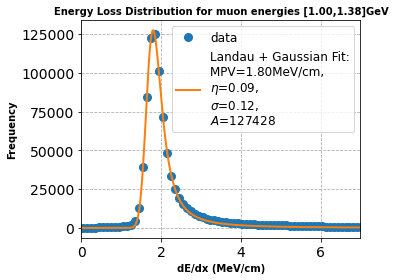

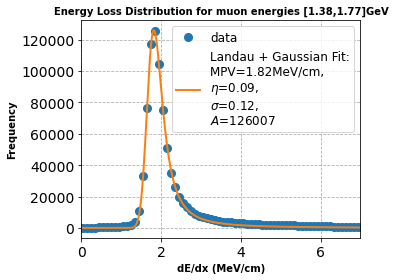

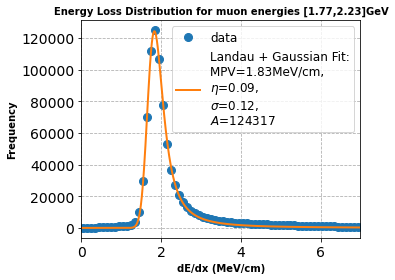

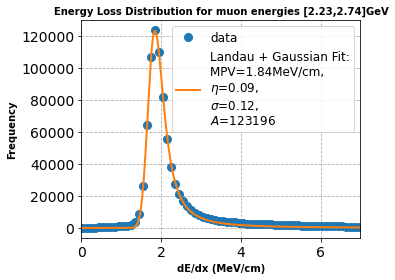

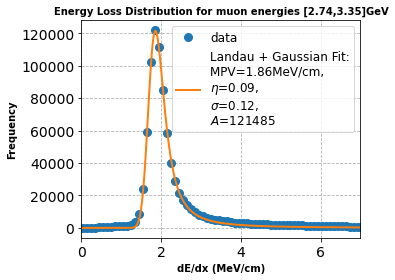

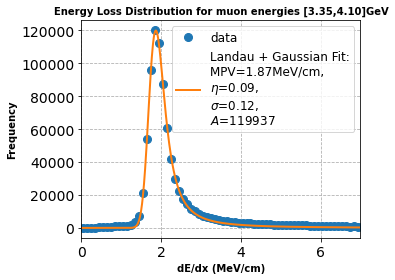

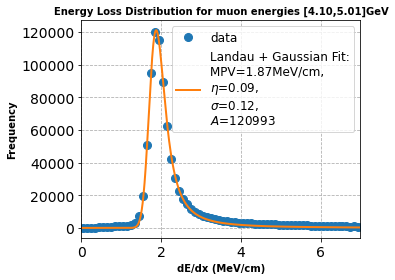

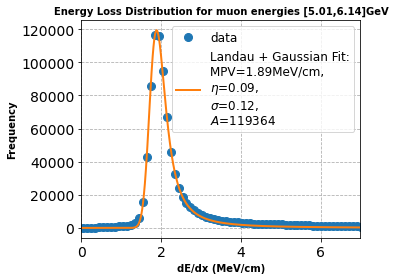

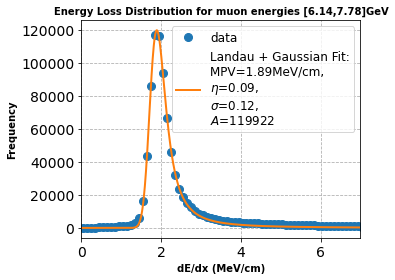

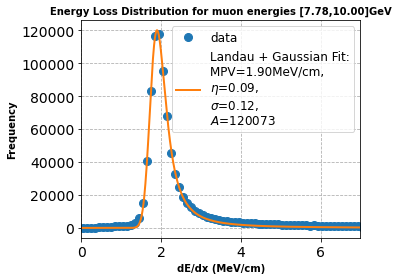

In [51]:
mpvs, avs = plot_freq_vs_dedx(num_bins=num_dedx_bins, show=True, savefile=False)
avs_data = []
for b in binned_dedx:
    avs_data.append(np.mean(b))

## Plotting and Checking Against Theory

In [52]:
avs_c = 'r'
mpvs_c = 'b'
true_ls = '-'
fit_ls = '--'
data_m = '^'
fit_m = 'o'

In [53]:
def savefig(fig, name):
    date = datetime.datetime.now()
    month_day = f'{date.month}-{date.day}/'
    path = r'./plots/' + month_day + name
    fig.savefig(path, bbox_inches='tight')

In [54]:
def plot_dedx_vs_e_data(with_fit_av=False, data_av=True, fit_mpv=True):    
    fig = plt.figure(figsize=(12,7))
    ax = plt.gca()
    if data_av:
        label = '$-$<dE/dx> from data'
        ax.errorbar(e_bin_centers, avs_data, label=label, color=avs_c, marker=data_m)
    if with_fit_av:
        label='$-$<dE/dx> from fit'
        ax.errorbar(e_bin_centers, avs, label=label, color=avs_c, marker=fit_m)
    if fit_mpv:
        label='$\Delta$p/dx from fits'
        ax.errorbar(e_bin_centers, mpvs, label=label, color=mpvs_c, marker=fit_m)
    ax.set_xscale('log')
    ax.set_xlabel('Muon Kinetic Energy (GeV)')
    ax.set_ylabel('Energy Loss (MeV/cm)')
    ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    
    return fig, ax

In [55]:
plt.style.use('./stylesheets/eloss.mplstyle')

In [56]:
fit_es = np.logspace(np.log10(min_e), np.log10(max_e), 1000) # kinetic energy (GeV) xdata for the fits
fit_es_mev = fit_es * 1000
ke = fit_es_mev

bethe_dedx = theory.dedx(ke, rest_e)                         # Standard Bethe curve, no fit
bethe_dedx_no_delta = theory.dedx(ke, rest_e, dens=False)    # Same, but without density correction

ke_bin_centers = np.asarray(e_bin_centers)*1000              # simulated kinetic energy (GeV) xdata converted to (MeV)

In [57]:
def av_fit(ke, fit_prefac, mee):
    return fit_prefac * theory.dedx(ke, rest_e, I=mee*10**(-6))

popt_av, pcov_av = curve_fit(av_fit, ke_bin_centers, avs_data, p0=(1, 188), bounds=((0.5, 100), (2, 300)))

fit_av_dedxs = av_fit(ke, *popt_av)
print(popt_av)

[  0.96624262 100.        ]


In [58]:
def mpv_fit(ke, t, I=theory.I):
    return theory.dpdx(ke, t, rest_e, I=I)
    
popt_mpv, pcov_mpv = curve_fit(mpv_fit, ke_bin_centers[1:], mpvs[1:], p0=2.5, bounds=(0,5))

fit_mpv_dedxs = mpv_fit(ke, *popt_mpv)

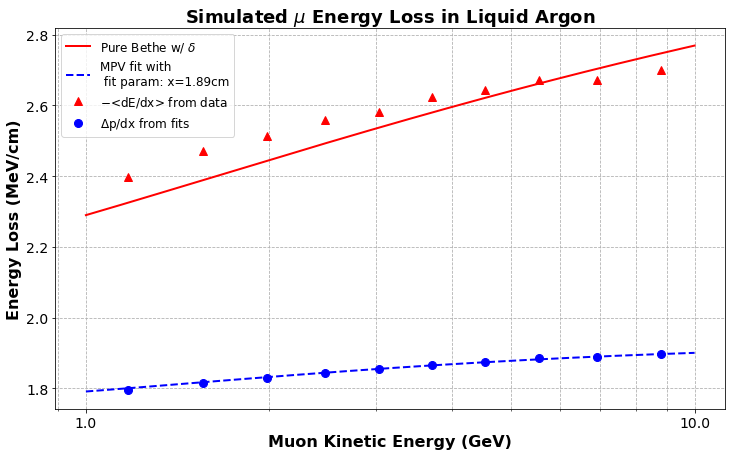

In [59]:
fig, ax = plot_dedx_vs_e_data()

ax.yaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.set_yscale('linear')

ax.plot(fit_es, bethe_dedx, label='Pure Bethe w/ $\delta$', color=avs_c, linestyle=true_ls)
# ax.plot(fit_es, fit_av_dedxs, label=f'E Loss Fit. \n fit params: A, I', color=avs_c, ls=fit_ls)
ax.plot(fit_es, fit_mpv_dedxs, label=f'MPV fit with \n fit param: x={popt_mpv[0]:.2f}cm', color=mpvs_c, ls=fit_ls)
ax.set_title("Simulated $\mu$ Energy Loss in Liquid Argon")
ax.legend()
fig.show()

### Notes
The MPV data is much better fit to the theoretical curve than the average value data. The one parameter fit is, from a purely visual standpoint, much better than even the two parameter fit of the Bethe equation. Furthermore the two parameter fit of the Bethe equation indicates physically unreasonable values of the mean excitation energy and the prefacor multiplying the equation, both of which have been independently dertermined by experiment to differ significantly. Some potential fixes to the average value data are presented above, although I am not confiedent they will prove to fix the disagreement entirely.
- The data for the average energy loss is almost entirely lower than the expected energy loss according to the Bethe equation. This may suggest that there is some sort of confounding data that is not selected out during the selection cuts. Or perhaps even that the selection cuts are too stringent, and are removing too many high-energy loss events, pulling the average down at these higher energies.
- The MPV data can be improved by performing a fit to each of the Landau distributed energy losses per energy bin and finding the maximum according to that fit. 
    - I am not certain about using a least-squares fit on the Landau data, just because there are so many data points that do not contribute to the principal peak we are concerned with. I will test this when I can.he 
- To better fit the Bethe curve I could also calculate the average of the Landau distribution in the fits, although I believe the Landau pdf diverges, so the mean is undefined. I think this is also reason to suspect that the mean of a Landau distributed set of random variables will never converge, indeed, it tends to grow without bound with the sample size: https://drupal.star.bnl.gov/STAR/blog/lisa/mean-landau-distribution-undefined.
- Need to continue working on obtaining the average dedx from the fit Landaus, rather than continuing to use the raw data.
    - I am not certain how well this works in principal. Treating the Landau distribution as a pdf $f_L(x)$ and performing the integral to find the expectation value
    $$\langle x\rangle=\int^\infty_{-\infty} xf_L(x)dx$$
    gives entirely different results from computing the average via Bethe-Bloch equation (shown above). I do not know why.
    - Furthermore, the data points that result from this numerical integration to find the average value are also highly variable, which is probably due to the rather significant integration error associated with the numerical caluclation of this integral.
- The average value plot in the fitted case also does not follow the trend of the graph of the Bethe-Bloch curve. Instead, it appears to flatten out at high energies, which makes me think there might be an energy cutoff at play here. The effects of such a cutoff are outlined in chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/viewer.html?pdfurl=https%3A%2F%2Fpdg.lbl.gov%2F2019%2Freviews%2Frpp2018-rev-passage-particles-matter.pdf&clen=2912706&chunk=true, section 33.2.8.

## MPV Residuals

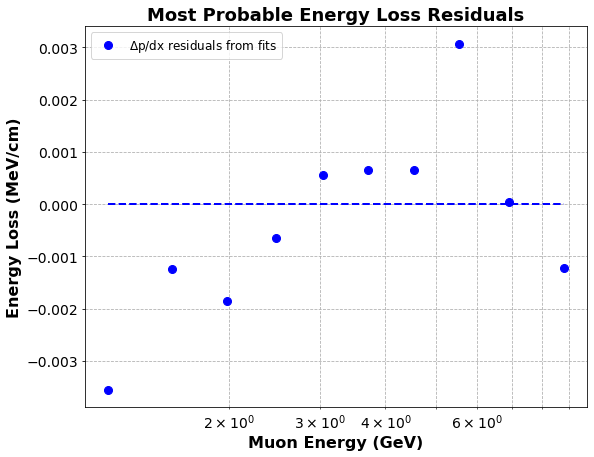

In [60]:
dp_cutoff = 0
expected_mpvs = np.array([ mpv_fit(x*1000, *popt_mpv) for x in e_bin_centers[dp_cutoff:] ])
zeros = np.zeros(len(e_bin_centers[dp_cutoff:]))

fig = plt.figure(figsize=(9,7))
ax = plt.gca()
ax.errorbar(e_bin_centers[dp_cutoff:], np.array(mpvs[dp_cutoff:])-expected_mpvs, fmt='o', label='$\Delta$p/dx residuals from fits', color = 'b')
ax.plot(e_bin_centers[dp_cutoff:], zeros, color="b", ls='--')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel('Muon Energy (GeV)')
ax.set_ylabel('Energy Loss (MeV/cm)')
plt.title("Most Probable Energy Loss Residuals")
fig.show()

## MPV Bounds

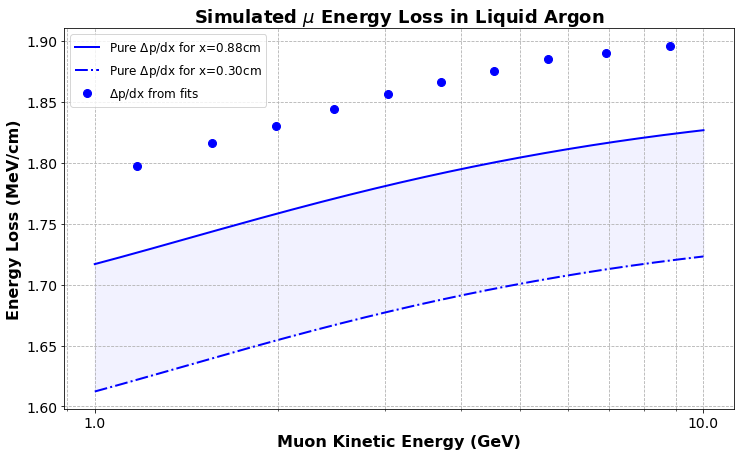

In [61]:
min_pitch = 0.3 # min_pitch of 1 fits well, see note below
max_pitch = min_pitch/np.cos(70*np.pi/180) # 70 degrees maximum pitch
uplim_mpvs = [ mpv_fit(x*1000, max_pitch) for x in fit_es ]
lolim_mpvs = [ mpv_fit(x*1000, min_pitch) for x in fit_es ]

fig, ax = plot_dedx_vs_e_data(data_av=False)
ax.set_yscale('linear')

ax.plot(fit_es, uplim_mpvs, ls='-', color='b', label=f'Pure $\Delta$p/dx for x={max_pitch:.2f}cm')
ax.plot(fit_es, lolim_mpvs, ls='-.', color='b', label=f'Pure $\Delta$p/dx for x={min_pitch:.2f}cm')
ax.fill_between(fit_es, lolim_mpvs, uplim_mpvs, color='b', alpha=0.05)

ax.set_title("Simulated $\mu$ Energy Loss in Liquid Argon")
ax.legend()
fig.show()

In [38]:
avlim_mpvs = [ mpv_fit(x*1000, 0.517) for x in e_bin_centers ]
print(np.mean((np.array(mpvs)-np.array(avlim_mpvs))/np.array(avlim_mpvs))*100)

7.1798793149560645


In [39]:
# I'm gonna divide up each binned_dedx into pitches by making the statistics in each pitch bin in the 
# 9th distribution equal. Hopefully this produces roughly equal statistics in the other distributions
num_bpd = 5
stat_bin_idx = 9
stat_d = binned_dedx[stat_bin_idx]
stat_p = binned_pitches[stat_bin_idx]
testsort = np.argsort(stat_p)
s_stat_d = stat_d[testsort]
s_stat_p = stat_p[testsort]
k, m = divmod(len(stat_p), num_bpd)
pitch_edges = [0.3] + [s_stat_p[(i+1)*k+min(i, m-1)] for i in range(num_bpd)]
pitch_edges[-1] = max_pitch
pitch_edges = np.array(pitch_edges)
pitch_avs = (pitch_edges[1:] + pitch_edges[:-1]) / 2

In [40]:
bp_mpvs = []
binned_dedxs_p_e = []
print("Data points per pitch bin:")
for bd, bp in zip(binned_dedx, binned_pitches):
    binlocs = np.digitize(bp, pitch_edges)-1
    
    bpds = [[] for i in range(num_bpd)]
    for i in range(len(binlocs)):
        b = binlocs[i]
        bpds[b].append(bd[i])
        
    print(min(len(bpd) for bpd in bpds))
    
    this_e_mpvs = []
    for bpd in bpds:
        xdata, ydata = generate_one_freq_vs_dedx(bpd, num_dedx_bins)
        fit_params = generate_fit(xdata, ydata)[0]
        mpv = fit_params[0]
        this_e_mpvs.append(mpv)
    
    binned_dedxs_p_e.append(bpds)
    bp_mpvs.append(this_e_mpvs)

Data points per pitch bin:
70133
80292
83067
83506
87155
96368
100912
110268
106663
123505
115061
114506
104606
106188
114145
111028
110125
103050
98122
90461


In [41]:
binned_dedxs_p_e = np.array(binned_dedxs_p_e)
print(binned_dedxs_p_e.shape)

(20, 5)


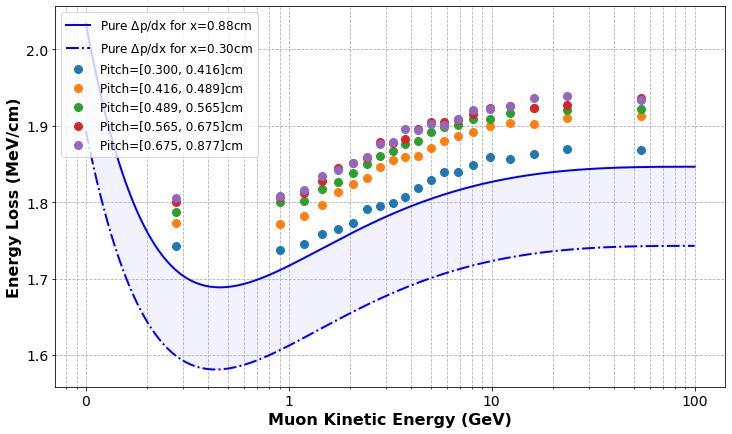

In [42]:
mpvs_per_pitch=list(zip(*bp_mpvs))

fig, ax = plot_dedx_vs_e_data(with_fit_av=False, data_av=False, fit_mpv=False)

for mpvs_i, i in zip(mpvs_per_pitch, range(len(pitch_edges))):
    ax.errorbar(e_bin_centers, mpvs_i, fmt='o', label=f'Pitch=[{pitch_edges[i]:.3f}, {pitch_edges[i+1]:.3f}]cm')
    
ax.plot(fit_es, uplim_mpvs, ls='-', color='b', label=f'Pure $\Delta$p/dx for x={max_pitch:.2f}cm')
ax.plot(fit_es, lolim_mpvs, ls='-.', color='b', label=f'Pure $\Delta$p/dx for x={min_pitch:.2f}cm')
ax.fill_between(fit_es, lolim_mpvs, uplim_mpvs, color='b', alpha=0.05)
ax.legend(loc='upper left')
fig.show()

Perhaps it is the case that the minimum pitch is normalized to 1. Thus, pitch is *just* $\frac{1}{\cos(\theta)}$, i.e. pitch is unitless. The problem with this is that I have checked the pitches for the raw data, and the minimum pitch definitely goes below 1, and it is very close to 0.3cm exactly. Furthermore, I have generated a raw ROOT histogram of the data for a Langau distribution, and found that the MPV agrees almost exactly with my calculated MPVs. Therefore, one of the following must be a cause of this discrepancy:
- There is some bias introduced when performing the selection cuts that I do. This is unlikeliy, because even without the selection cuts applied to the ROOT histogram, the most probable bin remains the same.
- The dedx listed in the .root file have a different definition from what we expect. dedx may purely represent the energy deposited onto the wire in the wire plane, regardless of the pitch of the plane. The resoning for this is that, in the data, high pitch events correspond to very low dedx values, meaning that there is some dependence of dedx on pitch. I am not certain what to make of this, need to think about it more.
    - Multiplying dedx_y by pitch_y leads to a ROOT histogram which is much more uniformly Langau-shaped (gets rid of the low-dedx peak). This may have something to do with the issue i.e. there is some nuance with the dedx calculation or some difference between the dedx definition I use here and the dedx present in the simulation.
    - Look into whether azimuthal angle is included in the definition of the pitch, or whether the angle used to caculate pitch is purely the polar angle with respect to the collection plane. If this is not currently accounted for, it could explain an the increase of the thickness parameter compared to expectation.
- There is some problem with the theoretical model of the mpv. Perhaps the thickness parameter means something different than we expect, or maybe the 0.3cm spacing is baked in there somehow.
- There is some problem with the simulation. This is highly unlikely, but I just state it for completeness.

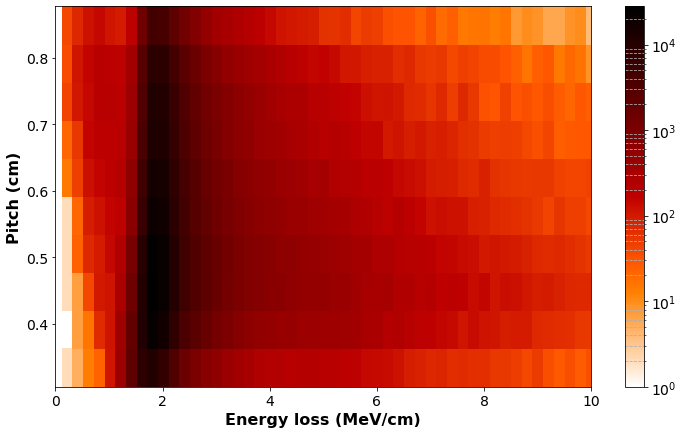

In [43]:
from matplotlib.colors import LogNorm
e_bin_num = 10
hist, xedges, yedges, _ = plt.hist2d(binned_dedx[e_bin_num], binned_pitches[e_bin_num], bins=[500, 10], norm=LogNorm(), cmap='gist_heat_r')
plt.colorbar()
plt.xlabel('Energy loss (MeV/cm)')
plt.ylabel('Pitch (cm)')
plt.xlim(0,10)
plt.title
plt.show()

In [44]:
mpvs_p_e = []
pitch_centers = (yedges[1:] + yedges[:-1])/2
dedx_centers = (xedges[1:] + xedges[:-1])/2
for dedx in hist.T:
    fit_params = generate_fit(dedx_centers, dedx)[0]
    mpvs_p_e.append(fit_params[0])

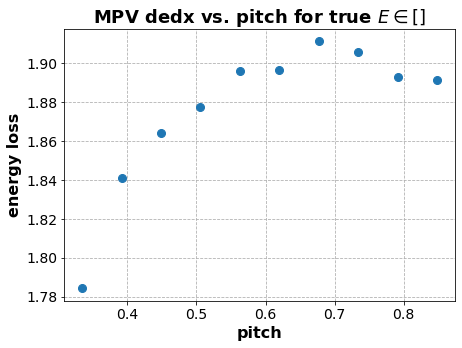

In [45]:
plt.figure(figsize=(7,5))
plt.errorbar(pitch_centers, mpvs_p_e, fmt='o')
plt.xlabel('pitch')
plt.ylabel('energy loss')
plt.title(r'MPV dedx vs. pitch for true $E\in[]$')
plt.show()

- Vertical slices, plot dedx as a function of pitch for a few energy bins

## Restricted Average Energy Loss

In [46]:
def av_R0_fit(ke, wcut, prefac, mee):
    return theory.dedx_R(ke, rest_e, wcut, K=prefac, I=mee*10**(-6))
popt_av_R0, pcov_av_R0 = curve_fit(av_R0_fit, ke_bin_centers, avs_data, p0=(10, theory.K, 188), maxfev=10000) #bounds=((0,0.2,186*10**(-6)),(100,4,190*10**(-6))),maxfev=10000)


def av_R1_fit(ke, wcut):
    return theory.dedx_R(ke, rest_e, wcut)
popt_av_R1, pcov_av_R1 = curve_fit(av_R1_fit, ke_bin_centers, avs_data, p0=(0.1), maxfev=10000)


def av_R2_fit(ke, wcut, a, b):
    return theory.dedx_R(ke + a, rest_e, wcut) + b
# popt_av_R2, pcov_av_R2 = curve_fit(av_R2_fit, ke_bin_centers, avs_data, p0=(0.1, 10, 1), maxfev=10000)


fit_av_R0_dedxs = av_R0_fit(ke, *popt_av_R0)
fit_av_R1_dedxs = av_R1_fit(ke, *popt_av_R1)
# fit_av_R2_dedxs = av_R2_fit(ke, *popt_av_R2)

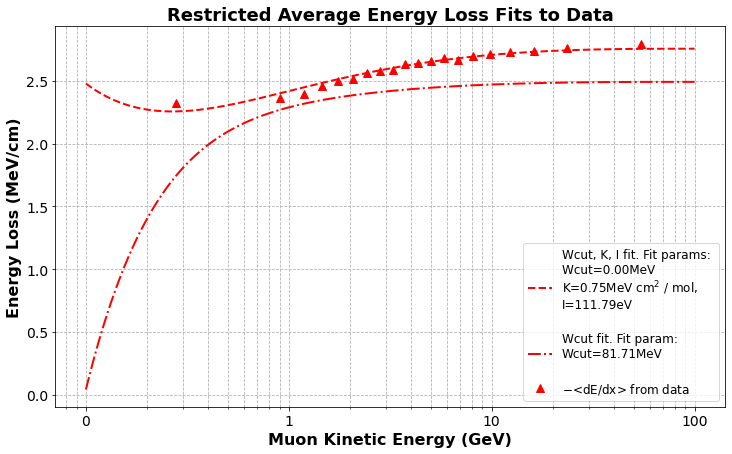

In [47]:
fig, ax = plot_dedx_vs_e_data(fit_mpv=False) 

ax.plot(fit_es, fit_av_R0_dedxs, label=f'Wcut, K, I fit. Fit params: \nWcut={popt_av_R0[0]:.2f}MeV \nK={popt_av_R0[1]:.2f}MeV cm$^2$ / mol, \nI={popt_av_R0[2]:.2f}eV\n', color=avs_c, ls='--')
ax.plot(fit_es, fit_av_R1_dedxs, label=f'Wcut fit. Fit param: \nWcut={popt_av_R1[0]:.2f}MeV\n', color=avs_c, ls='-.')
# ax.plot(fit_es[50:], fit_av_R2_dedxs[50:], label=f'Wcut + Translation Fit. Fit params: \nWcut={popt_av_R2[0]:.2f}MeV, \na={popt_av_R2[1]:.2f}, \nb={popt_av_R2[2]:.2f}\n', color=avs_c, ls=':')
ax.set_title("Restricted Average Energy Loss Fits to Data")
ax.legend()

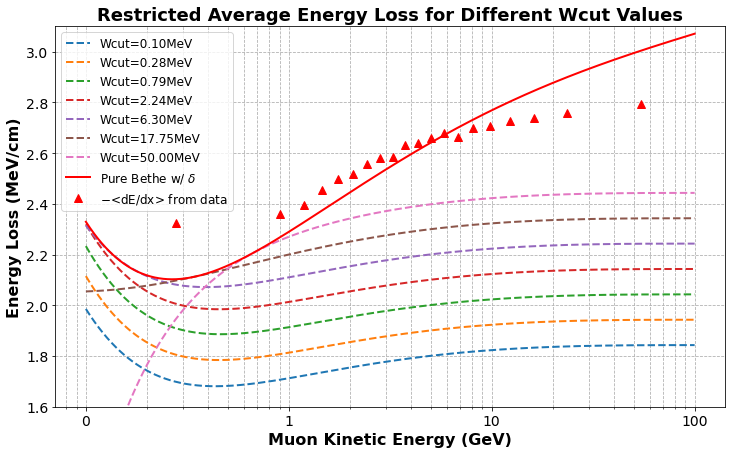

In [48]:
fig, ax = plot_dedx_vs_e_data(fit_mpv=False)

min_wcut = 0.1
max_wcut = 50
num_plotted = 7
wcuts = np.logspace(np.log10(min_wcut), np.log10(max_wcut), num_plotted)
for wcut in wcuts:
    av_dedxs_R = theory.dedx_R(ke, rest_e, wcut)
    label=f'Wcut={wcut:.2f}MeV'
    ax.plot(fit_es, av_dedxs_R, label=label, ls=fit_ls)

ax.plot(fit_es, bethe_dedx, label='Pure Bethe w/ $\delta$', color=avs_c, linestyle=true_ls)
ax.set_title("Restricted Average Energy Loss for Different Wcut Values")
ax.legend()
ax.set_ylim(1.6, 3.1)
fig.show()

### Notes on Restricted Average Energy Loss
The equation for modelling the restricted average energy loss is differs somewhat from the data. This difference was present in the Bethe equation fit, but it was just less apparent than the deviations at the high end.
- It may be the case that I am not selecting out high energy outlier events correctly from the data. This might bring up the average energy loss much higher above where it should be, so I will need to check the data more thouroughly to see if there are any such confounding events to get rid of.
- Another consideration is that the location of the minimum ionization value differs in the wcut fits from the data. The location of the minimum varies very little with wcut, so this suggests there is some other problem with the data. I have already subtracted off the rest energy of the muon, so in theory we shold be working with solely the muon kinetic energy here, but there may be something I missed. It might also be the case that the backtracked energy of the simulated muons is already the kinetic energy, but I believe this would shift the minimum location the other way, which is not good.